# Figures of AU-emotion mappings project

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Figure 1: emotion expression/perception symmetry
Made manually using google draw.

## Figure 2: overview method
Made in google draw, but used the mapping matrix below:

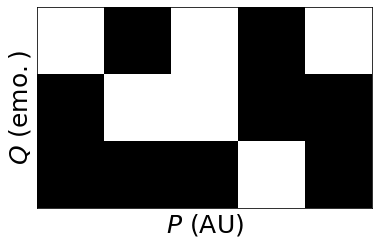

In [2]:
#AUs = ['AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU7', 'AU9', 'AU10', 'AU11', 'AU12', 'AU13', 'AU14',
#       'AU15', 'AU16', 'AU17', 'AU20', 'AU22', 'AU23', 'AU24', 'AU25', 'AU26']
M_classes = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Surprise', 'Sadness']
#M_mapping = [
#    ['AU4', 'AU5', 'AU7', 'AU23'],
#    ['AU9', 'AU15', 'AU16'],
#    ['AU1', 'AU2', 'AU4', 'AU5', 'AU20', 'AU26'],
#    ['AU6', 'AU12'],
#    ['AU1', 'AU4', 'AU5'],
#    ['AU1', 'AU2', 'AU5', 'AU26']
#]
AUs = ['AU4', 'AU9', 'AU10', 'AU12', 'AU23']
M_mapping = [
    ['AU4', 'AU23', 'AU10'],
    ['AU9', 'AU10'],
    ['AU12']
]

M = [[1 if au in mapp else 0 for au in AUs]
     for mapp in M_mapping]
M = np.array(M)
plt.imshow(M, cmap='gray', aspect=1)
plt.xticks([])
plt.yticks([])
plt.ylabel(r'$Q\ \mathrm{(emo.)}$', fontsize=25)
plt.xlabel(r'$P\ \mathrm{(AU)}$', fontsize=25)
plt.show()

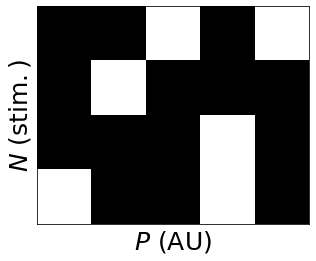

In [3]:
#S_ = [
#    ['AU1', 'AU8', 'AU9'],
#    ['AU6', 'AU26'],
#    ['AU4', 'AU25']   # TO CHANGE!
#]
S_ = [
    ['AU10', 'AU23'],
    ['AU9'],
    ['AU12'],
    ['AU4', 'AU12']
]

S = [[1 if au in stim else 0 for au in AUs]
      for stim in S_]
E = [0, 1, 2, 1]
E = np.array([e == np.arange(3) for e in E]).astype(int)
S = np.array(S)
plt.imshow(S, cmap='gray', aspect=1)
plt.xticks([])
plt.yticks([])
plt.ylabel(r'$N\ \mathrm{(stim.)}$', fontsize=25)
plt.xlabel(r'$P\ \mathrm{(AU)}$', fontsize=25)
plt.show()

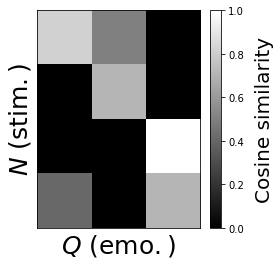

In [4]:
norm = np.sqrt((S ** 2).sum(axis=1, keepdims=True) @ (M.T ** 2).sum(axis=0, keepdims=True)) 
ϕ = (S @ M.T) / norm

# Alternatively, using scikit-learn:
# from sklearn.metrics.pairwise import cosine_similarity
# cosine_similarity(S, M)

im = plt.imshow(ϕ, cmap='gray', aspect=1)
plt.xticks([])
plt.yticks([])
plt.colorbar(im,fraction=0.05, pad=0.03)
plt.text(3.5, 1.5, 'Cosine similarity', rotation=90, va='center', fontsize=20)
plt.ylabel(r'$N\ \mathrm{(stim.)}$', fontsize=25)
plt.xlabel(r'$Q\ \mathrm{(emo.)}$', fontsize=25)
plt.show()

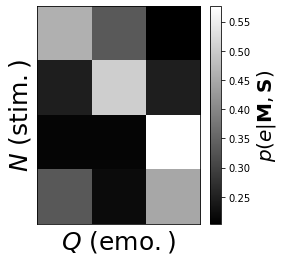

In [5]:
def softmax_2d(arr, beta):
    """ Vectorized softmax implementation including an inverse temperature
    parameter (beta). It assumes a 2D array with stimuli x features (similarities). """
    scaled = beta * arr
    num = np.exp(scaled - scaled.max(axis=1, keepdims=True))
    denom = np.sum(num, axis=1, keepdims=True)
    return num / denom

pE = softmax_2d(ϕ, 1)
im = plt.imshow(pE, cmap='gray', aspect=1)
plt.xticks([])
plt.yticks([])
plt.colorbar(im,fraction=0.05, pad=0.03)
plt.text(3.5, 1.5, r'$p(e | \mathbf{M}, \mathbf{S})$', rotation=90, va='center', fontsize=20)
plt.ylabel(r'$N\ \mathrm{(stim.)}$', fontsize=25)
plt.xlabel(r'$Q\ \mathrm{(emo.)}$', fontsize=25)
plt.show()

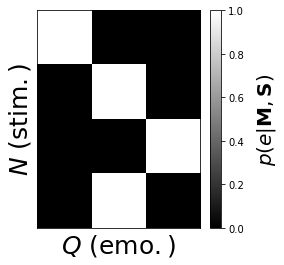

In [6]:
im = plt.imshow(E, cmap='gray', aspect=1)
plt.xticks([])
plt.yticks([])
plt.colorbar(im,fraction=0.05, pad=0.03)
plt.text(3.5, 1.5, r'$p(e | \mathbf{M}, \mathbf{S})$', rotation=90, va='center', fontsize=20)
plt.ylabel(r'$N\ \mathrm{(stim.)}$', fontsize=25)
plt.xlabel(r'$Q\ \mathrm{(emo.)}$', fontsize=25)
plt.show()

In [7]:
print(pE.round(2))
print(E)

[[0.46 0.34 0.2 ]
 [0.25 0.5  0.25]
 [0.21 0.21 0.58]
 [0.33 0.22 0.45]]
[[1 0 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]]


[Text(0, 0, ''), Text(1, 0, ''), Text(2, 0, '')]

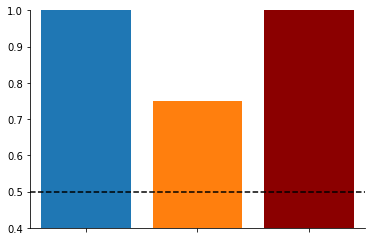

In [8]:
from sklearn.metrics import roc_auc_score
#mask = E.sum(axis=0) != 0
#roc_auc_score(E[:, mask], softmax_2d(ϕ[:, mask], 1))
score = roc_auc_score(E, pE, average=None)

plt.bar([0, 1, 2], score, color=['tab:blue', 'tab:orange', 'darkred'])
sns.despine()
plt.xlim(-0.5, 2.5)
plt.ylim(0.4, 1)
plt.axhline(0.5, ls='--', c='k')
plt.xticks([0, 1, 2])
plt.gca().set_xticklabels([])


## Figure 3: noise ceiling explanation
Made in google draw.

## Figure 4: MDS

In [9]:
map2leg = {
    'Darwin': 'Darwin (1886)',
    'Matsumoto2008': 'Matsumoto et al. (2008)',
    'Keltner2019': 'Keltner et al. (2019)',
    'Cordaro2018ref': 'Cordaro et al.\n(2008; ref.)',
    'Cordaro2018IPC': 'Cordaro et al.\n(2008; ICP)',
    'Ekman': 'EMFACS'
}

files = [
    '../data/Darwin.tsv',
    '../data/Matsumoto2008.tsv',
    '../data/Keltner2019.tsv',
    '../data/Cordaro2018ref.tsv',
    '../data/Cordaro2018IPC.tsv',
    '../data/Ekman.tsv'
]
m_dfs = [pd.read_csv(f, sep='\t', index_col=0) for f in files]
map_names = list(map2leg.values())
emo_names = list(m_dfs[0].index.unique())

In [ ]:
import matplotlib.lines as mlines
from sklearn.manifold import MDS

idx = np.concatenate([[i] * m_df.shape[0] for i, m_df in enumerate(m_dfs)])
mds = MDS(random_state=1)
# Fit MDS on all (i.e., conca|tenated) theory matrices
m_mds = mds.fit_transform(pd.concat(m_dfs, axis=0))

# Plot each embedding separately
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(14, 8), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    this_mds = m_mds[idx == i, :]
    sns.scatterplot(this_mds[:, 0], this_mds[:, 1], hue=m_dfs[i].index, ax=ax,
                    legend=False, marker='X', s=120)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3.5, 3.5)
    ax.grid()
    ax.set_title(map_names[i], fontsize=18)
    
ax = axes.flatten()[2]
current_palette = sns.color_palette()
ax.legend(handles=[mlines.Line2D([], [], color=current_palette[i], marker='X', linestyle='None', markersize=15, label=e)
                   for i, e in enumerate(sorted(list(emo_names)))],
          loc='upper right',
          frameon=False,
          fontsize=15,
          bbox_to_anchor=(0.5, 0, 1, 1)
)
fig.text(-0.01, 0.5, 'Dim. 1', fontsize=20, rotation=90, va='center')
fig.text(0.45, -0.015, 'Dim. 2', fontsize=20, ha='center')
fig.tight_layout();

In [ ]:
subs = [f'sub-{str(i+1).zfill(2)}' for i in range(60)]
dfs = []
for sub in subs:
    df = pd.read_csv(f'../data/ratings/{sub}_ratings.tsv', sep='\t', index_col=0).iloc[:, :-2]
    dfs.append(df)

df = pd.concat(dfs, axis=0)

In [ ]:
#mds = MDS()
mds_values = mds.fit_transform(df.drop_duplicates().values)

In [ ]:
sns.jointplot(x=mds_values[:, 0], y=mds_values[:, 1])

## Figure 5: main results plot

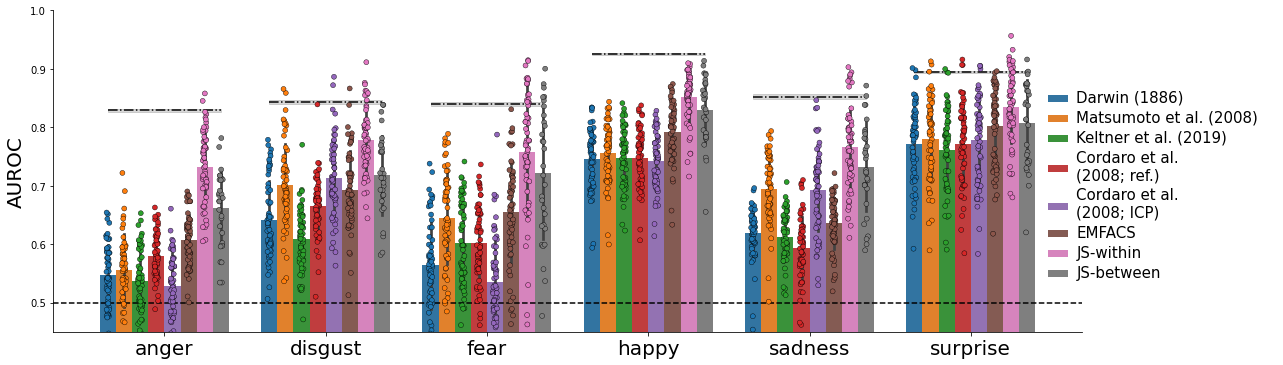

In [11]:
ymin = 0.45
ymax = 1
chance_level = .5

df = pd.read_csv('../results/scores.tsv', sep='\t', index_col=0)
df = df.replace(map2leg)
df_jsw = pd.read_csv('../results/JS-within_scores.tsv', sep='\t', index_col=0)
df_jsb = pd.read_csv('../results/JS-between_scores.tsv', sep='\t', index_col=0)
df = pd.concat((df, df_jsw, df_jsb), axis=0)

nc = pd.read_csv('../results/noise_ceiling2.tsv', sep='\t', index_col=0)

g = sns.catplot(x='emotion', y='score', data=df, hue='mapping',
                kind="bar", aspect=3, height=5, ci='sd')
g._legend.set_title('')
g._legend.set_bbox_to_anchor([1.025, 0.5])

plt.setp(g._legend.get_texts(), fontsize=15)

ax = sns.stripplot(x='emotion', y='score', hue='mapping',
                   edgecolor='black', linewidth=0.4, data=df,
                   dodge=True, jitter=True)

ax.set_xlabel('')
ax.set_ylabel('AUROC', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)

n_tk = df['mapping'].unique().size
for i in range(6):
    this_nc = np.array([nc['noise_ceiling'].iloc[i]] * 6)
    this_sd = np.array([nc['sd'].iloc[i]] * 6)
    plt.plot(np.linspace(i-0.35, i+0.35, num=6), this_nc, c='k', ls='-.')
    plt.fill_between(
        np.linspace(i-0.35, i+0.35, num=6),
        this_nc - this_sd, this_nc + this_sd,
        color='gray', alpha=0.3
)

ax = plt.gca()
ax.set_facecolor('white')
ax.set_ylim(ymin, ymax)
ax.axhline(chance_level, c='k', ls='--')
ax.legend_.remove()
#ax.text(-1, 1.05, 'A', fontsize=35)
plt.savefig('Figure5a.png', bbox_inches='tight', dpi=200, facecolor='white')

In [ ]:
g = sns.catplot(x='mapping', y='score', data=df, hue='emotion',
                kind="bar", aspect=3, height=5, ci='sd')
g._legend.set_title('')
plt.setp(g._legend.get_texts(), fontsize=15)

ax = sns.stripplot(x='mapping', y='score', hue='emotion',
              edgecolor='black', linewidth=0.4, data=df,
              dodge=True, jitter=True)

ax.set_xlabel('')
ax.set_ylabel('AUROC', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=13.5)

n_emo = df['emotion'].unique().size
for i in range(n_tk):
    this_nc = nc['noise_ceiling']
    this_sd = nc['sd']
    plt.plot(np.linspace(i-0.35, i+0.35, num=6), this_nc, c='k', ls='-.')
    plt.fill_between(
        np.linspace(i-0.35, i+0.35, num=6),
        this_nc - this_sd, this_nc + this_sd,
        color='gray', alpha=0.3
)

ax = plt.gca()
ax.set_ylim(ymin, ymax)
ax.axhline(chance_level, c='k', ls='--')
ax.legend_.remove()
ax.text(-1, 1.05, 'B', fontsize=35)
plt.savefig('Figure5b.png')

## Figure 6

In [ ]:
nc = pd.read_csv('../results/noise_ceiling_per_intensity_level.tsv', sep='\t', index_col=0)
df_int = pd.read_csv('../results/score_per_intensity_quantile.tsv', sep='\t', index_col=0)
df_int = df_int.replace(map2leg)
g = sns.catplot(x='emotion', y='score', data=df_int, hue='intensity', row='mapping',
                kind="bar", aspect=3, height=5, ci='sd')

g._legend.set_title(' intensity\n quantile')
plt.setp(g._legend.get_title(), fontsize=15)
plt.setp(g._legend.get_texts(), fontsize=15)
for i, ax in enumerate(g.axes.flatten()):
    ax.text(-.6, 1, map_names[i], fontsize=24, verticalalignment='top')
    ax.set_title('')
    for ii, emo in enumerate(nc['emotion'].unique()):
        this_nc = nc.loc[nc['emotion'] == emo, 'noise_ceiling']
        this_sd = nc.loc[nc['emotion'] == emo, 'sd']
        ax.plot(np.linspace(ii-0.4, ii+0.4, num=4), this_nc, c='k', ls='-.')
        ax.fill_between(
            np.linspace(ii-0.4, ii+0.4, num=4),
            this_nc - this_sd, this_nc + this_sd,
            color='gray', alpha=0.3
        )
        ax.set_ylim(ymin, ymax)
        ax.axhline(0.5, ls='--', c='k')
        ax.set_ylabel("AUROC", fontsize=20)

g.set_xlabels('')
g.set_xticklabels(df['emotion'].unique(), fontsize=20)

g._legend.set_bbox_to_anchor([1.05, 0.9])
plt.subplots_adjust(hspace=0.2)
fig = plt.gcf()
fig.tight_layout()
fig.savefig('Figure6.png')
#plt.close()

## Figure 7

In [ ]:
nc = pd.read_csv('../results/noise_ceiling_per_typicality_level.tsv', sep='\t', index_col=0)
df_int = pd.read_csv('../results/score_per_typicality_quantile.tsv', sep='\t', index_col=0)
df_int = df_int.replace(map2leg)
g = sns.catplot(x='emotion', y='score', data=df_int, hue='max_sim', row='mapping',
                kind="bar", aspect=3, height=5, ci='sd')

g._legend.set_title(' typicality\n quantile')
plt.setp(g._legend.get_title(), fontsize=15)
plt.setp(g._legend.get_texts(), fontsize=15)
for i, ax in enumerate(g.axes.flatten()):
    ax.text(-.6, 1, map_names[i], fontsize=24, verticalalignment='top')
    ax.set_title('')
    for ii, emo in enumerate(nc['emotion'].unique()):
        this_nc = nc.loc[nc['emotion'] == emo, 'noise_ceiling']
        this_sd = nc.loc[nc['emotion'] == emo, 'sd']
        ax.plot(np.linspace(ii-0.4, ii+0.4, num=4), this_nc, c='k', ls='-.')
        ax.fill_between(
            np.linspace(ii-0.4, ii+0.4, num=4),
            this_nc - this_sd, this_nc + this_sd,
            color='gray', alpha=0.3
        )
        ax.set_ylim(ymin, ymax)
        ax.axhline(0.5, ls='--', c='k')
        ax.set_ylabel("AUROC", fontsize=20)

g.set_xlabels('')
g.set_xticklabels(df['emotion'].unique(), fontsize=20)

g._legend.set_bbox_to_anchor([1.05, 0.9])
plt.subplots_adjust(hspace=0.2)
fig = plt.gcf()
fig.tight_layout()
fig.savefig('Figure6.png')
#plt.close()

## Hyperparameter figure

In [ ]:
nc = pd.read_csv('../results/noise_ceiling.tsv', sep='\t', index_col=0)
hp_df = pd.read_csv('../results/hyperparameter_scores.tsv', sep='\t', index_col=0)
KERNEL = 'cosine'
g = sns.catplot(x='emotion', y='score', data=hp_df.query("kernel == @KERNEL"), hue='beta', row='mapping',
                kind="bar", aspect=3, height=5, ci='sd')

g._legend.set_title(r'$\beta$')
plt.setp(g._legend.get_title(), fontsize=25)
plt.setp(g._legend.get_texts(), fontsize=25)
for i, ax in enumerate(g.axes.flatten()):
    ax.text(-.6, 1, map_names[i], fontsize=24, verticalalignment='top')
    ax.set_title('')
    for ii, emo in enumerate(nc['emotion'].unique()):
        this_nc = nc.loc[nc['emotion'] == emo, 'noise_ceiling']
        this_sd = nc.loc[nc['emotion'] == emo, 'sd']
        ax.plot(np.linspace(ii-0.4, ii+0.4, num=5), [this_nc]*5, c='k', ls='-.')
        ax.fill_between(
            np.linspace(ii-0.4, ii+0.4, num=5),
            this_nc - this_sd, this_nc + this_sd,
            color='gray', alpha=0.3
        )
        ax.set_ylim(ymin, ymax)
        ax.axhline(0.5, ls='--', c='k')
        ax.set_ylabel("AUROC", fontsize=20)

g.set_xlabels('')
g.set_xticklabels(df['emotion'].unique(), fontsize=20)

g._legend.set_bbox_to_anchor([1.05, 0.9])
plt.subplots_adjust(hspace=0.2)
fig = plt.gcf()
fig.tight_layout();

In [ ]:
hp_df = pd.read_csv('../results/hyperparameter_scores.tsv', sep='\t', index_col=0)
BETA = 1
g = sns.catplot(x='emotion', y='score', data=hp_df.query("beta == @BETA"), hue='kernel', row='mapping',
                kind="bar", aspect=3, height=5, ci='sd')

g._legend.set_title('Kernel')
plt.setp(g._legend.get_title(), fontsize=25)
plt.setp(g._legend.get_texts(), fontsize=25)
for i, ax in enumerate(g.axes.flatten()):
    ax.text(-.6, 1, map_names[i], fontsize=24, verticalalignment='top')
    ax.set_title('')
    for ii, emo in enumerate(nc['emotion'].unique()):
        this_nc = nc.loc[nc['emotion'] == emo, 'noise_ceiling']
        this_sd = nc.loc[nc['emotion'] == emo, 'sd']
        ax.plot(np.linspace(ii-0.4, ii+0.4, num=5), [this_nc]*5, c='k', ls='-.')
        ax.fill_between(
            np.linspace(ii-0.4, ii+0.4, num=5),
            this_nc - this_sd, this_nc + this_sd,
            color='gray', alpha=0.3
        )
        ax.set_ylim(ymin, ymax)
        ax.axhline(0.5, ls='--', c='k')
        ax.set_ylabel("AUROC", fontsize=20)

g.set_xlabels('')
g.set_xticklabels(df['emotion'].unique(), fontsize=20)

g._legend.set_bbox_to_anchor([1.1, 0.9])
plt.subplots_adjust(hspace=0.2)
fig = plt.gcf()
fig.tight_layout();

## Figure x: bias simulations

In [ ]:
df_naus = pd.read_csv('../results/scores_bias_simulation_n_aus.tsv', sep='\t', index_col=0)
df_naus = df_naus.groupby(['mapping', 'n_aus', 'emotion']).mean().reset_index()

df_nconf = pd.read_csv('../results/scores_bias_simulation_n_configs.tsv', sep='\t', index_col=0)
df_nconf = df_nconf.groupby(['mapping', 'n_configs', 'emotion']).mean().reset_index()

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(12, 5))
sns.barplot(x='n_aus', y='score', data=df_naus, ci='sd', ax=axes[0])
sns.barplot(x='n_configs', y='score', data=df_nconf, ci='sd', ax=axes[1])
sns.despine()
axes[0].set_ylim(0.2, 0.8)
for ax in axes:
    ax.axhline(0.5, ls='--', c='k')

axes[0].set_ylabel('AUROC', fontsize=20)
axes[1].set_ylabel('')
axes[0].set_xlabel('Number of AUs per config', fontsize=20)
axes[1].set_xlabel('Number of configs per class', fontsize=20)

axes[0].text(-0.9, 0.85, 'A', fontsize=35)
axes[1].text(-0.9, 0.85, 'B', fontsize=35)

fig.tight_layout()

In [ ]:
from scipy.stats import ttest_1samp
for emo in df_naus.emotion.unique():
    for n_au in df_naus.n_aus.unique():
        tmp_df = df_naus.query("emotion == @emo & n_aus == @n_au")
        print(ttest_1samp(tmp_df.score, 0.5))

## Probabilistic predictions vs. discrete predictions

In [ ]:
pp_df = pd.read_csv('../results/prob_vs_discrete_scores.tsv', sep='\t', index_col=0)
g = sns.catplot(x='mapping', y='score', data=pp_df, hue='method',
                kind="bar", aspect=3, height=5, ci='sd')
ax = g.axes[0, 0]
ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
ax.set_xlabel('')
ax.set_ylabel('Score', fontsize=20)
ax.set_ylim(0.4, 1)
ax.axhline(0.5, ls='--', c='k')
leg = g._legend
leg.set_title('')
leg.get_texts()[0].set_text('discrete')
leg.get_texts()[0].set_fontsize(20)
leg.get_texts()[1].set_text('probabilistic')
leg.get_texts()[1].set_fontsize(20)
leg.set_bbox_to_anchor([0, 0, 0.2, 1.75])

In [ ]:
m = np.array([0, 0, 0, 0.25, 0.75])
s1 = np.array([0, 0, 0, 0.25, 0.75])
s2 = np.array([0, 0, 0, 0.5, 1])

print("Linear kernel similarity:")
print('s1:', s1 @ m)
print('s2:', s2 @ m)

print("\nCosine kernel similarity:")
print('s1:', (s1 @ m) / (np.linalg.norm(s1) * np.linalg.norm(m)))
print('s2:', (s2 @ m) / (np.linalg.norm(s2) * np.linalg.norm(m)))

## ML analysis between-sub

In [ ]:
ml_df = pd.read_csv('../results/method-ml_analysis-between_auroc.tsv', sep='\t', index_col=0)

g = sns.catplot(x='emotion', y='score', data=ml_df,
                kind="bar", aspect=3, height=5, ci='sd')

g = sns.stripplot(x='emotion', y='score', data=ml_df,
                  edgecolor='black', linewidth=0.4)

ax = plt.gca()
ax.axhline(0.5, ls='--', c='k')
ax.set_ylim(0.4, 1.)

nc = pd.read_csv('../results/noise_ceiling_half_subjects.tsv', sep='\t', index_col=0)
#nc = nc.query("participant_id == 'between_subjects' & intensity == 0")

for i in range(6):
    this_nc = np.array([nc['noise_ceiling'].iloc[i]])
    this_sd = np.array([nc['sd'].iloc[i]])
    plt.plot(np.linspace(i-0.35, i+0.35, num=6), [this_nc]*6, c='k', ls='-.', lw=0.5)
    plt.fill_between(
        np.linspace(i-0.35, i+0.35, num=6),
        this_nc - this_sd, this_nc + this_sd,
        color='gray', alpha=0.3
    )

plt.xlabel('')
plt.ylabel('AUROC', fontsize=20)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), fontsize=20)

## Repeats

In [ ]:
import pandas as pd
from glob import glob
import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
dfs = sorted(glob('../data/ratings/*.tsv'))
df = pd.concat([pd.read_csv(df, sep='\t', index_col=0).query("emotion != 'other'").loc[:, 'emotion'] for df in dfs])
df = df.loc[df.index != 'empty']
df = df.sort_index()
uniq_idx = df.index.unique()

In [ ]:
idx = df.index.tolist()
idx[-1] = 'test'
df.index = idx

In [ ]:
def compute_noise_ceiling(y, only_repeats=True, n_bootstraps=0):
    """ Computes a noise ceiling given a series y with possible 
    repeated indices. """

    if only_repeats:
        # Compute noise ceiling only on repeated trials! (No bias upwards)
        repeats = y.loc[y.index.duplicated()].index.unique()
        y = y.loc[repeats]

    # Compute the "optimal" predictions:
    # 1. Per unique index, compute the count per emotion
    # 2. Divide counts by sum (per unique index)
    # 3. Unstack to move emotion groups to columns
    # 4. Fill NaNs (no ratings) with 0
    opt = (y.reset_index() \
        .groupby(['index', 'emotion']).size() \
        .groupby(level=0) \
        .apply(lambda x: x / x.sum()) \
        .unstack(level=1) \
        .fillna(0)
    )

    if n_bootstraps != 0:  # do bootstrapping
        # Pre-allocate noise ceiling array
        nc = np.zeros((n_bootstraps, opt.shape[1]))

        for i in tqdm(range(n_bootstraps)):
            # Resample optimal predictions
            opt2 = opt.copy().sample(frac=1, replace=True)
            # Remove non-used trials from y
            y2 = y.copy().loc[opt2.index].sort_index()
            # Repeat the optimal trials according to the repeats in y2
            opt_rep = opt.loc[y2.index, :].sort_index()
            # Compute noise ceiling 
            nc[i, :] = roc_auc_score(pd.get_dummies(y2).values, opt_rep.values, average=None)
    else:
        # Same as above, but on the original opt array
        opt_rep = opt.copy().loc[y.index, :].sort_index()
        nc = roc_auc_score(pd.get_dummies(y).values, opt_rep.values, average=None)

    return nc

compute_noise_ceiling(df, True, 10)